In [825]:
import sys
import os


sys.path.append("../src")


import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import sys
import os

import math

from utils import number_split, create_mix
from data_process import load_wls_adress_AddDomain
from process_SHAC import load_process_SHAC
from custom_distance import KL



from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import pickle


In [5]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F


# Test two ways of embedding... same!?

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence', 
             'Sentences are passed as a list of string.',
             'The quick brown fox jumps over the lazy dog.']

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [ ]:
sentence

In [ ]:
embedding.shape

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


In [ ]:
encoded_input = tokenizer(sentences, max_length = 120, padding=True, truncation=True, return_tensors='pt')


In [ ]:
encoded_input

In [ ]:
with torch.no_grad():
    model_output = model(**encoded_input)


In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [ ]:
model_output['last_hidden_state']

In [ ]:
# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

In [ ]:
sentence_embeddings[0]

In [ ]:
model.encode(sentences[0])

In [ ]:
model.encode(sentences[0])[:20]

In [ ]:
sentence_embeddings[0][:20]

In [ ]:
encoded_input['attention_mask']

In [ ]:
model_output[0]

# Use this Embedding

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# https://www.sbert.net/index.html

# Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence', 
             'Sentences are passed as a list of string.',
             'The quick brown fox jumps over the lazy dog.']

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)


In [ ]:
embeddings.shape

# Load Data

In [ ]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

# Split

In [ ]:
n_test = 150
train_test_ratio = 4


valid_full_settings = []
for combination in itertools.product([0.1, 0.5], 
                                    [0.2, 0.6], 
                                     np.arange(0.1, 0.999, 0.1),
                                     np.arange(0, 5, 0.05)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if number_setting is not None:
        valid_full_settings.append(number_setting)
    

In [ ]:
len(valid_full_settings)

In [ ]:
valid_full_settings[0]

In [ ]:
dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= valid_full_settings[0])

In [ ]:
dfs.keys()

In [ ]:
dfs['train']

In [ ]:
dfs['test']

# Sentence BERT

## Encode

In [ ]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [ ]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

## Logistic Regression

### All

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=embeddings_X_train, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=embeddings_X_test)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

### t-SNE

In [ ]:
embeddings_X_train

In [ ]:
x_train_tsne = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(embeddings_X_train)
x_test_tsne  = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(embeddings_X_test)



In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tsne, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tsne)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

In [ ]:
# metrics.roc_auc_score(
#                 y_true=y_test,
#                 y_score=y_probs[:,1],
#             )

# metrics.f1_score(y_true=y_test, y_pred=y_probs[:,1]>0.5)

# TFIDF

In [ ]:
vectorizer = TfidfVectorizer(use_idf = True,
                                    ngram_range = (1,1))

In [ ]:
vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

In [ ]:
x_train_tfidf = vectorizer.transform(dfs['train']['text']).toarray()
x_test_tfidf = vectorizer.transform(dfs['test']['text']).toarray()

## Logistic Regression

### All features

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tfidf, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tfidf)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

### t-SNE

In [ ]:
x_train_tfidf_tsne = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(x_train_tfidf)
x_test_tfidf_tsne  = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(x_test_tfidf)



In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tfidf_tsne, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tfidf_tsne)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

In [ ]:
metrics.roc_auc_score(
                y_true=y_test,
                y_score=y_probs[:,1],
            )

In [ ]:
metrics.f1_score(y_true=y_test, y_pred=y_probs[:,1]>0.5)

### PCA

In [ ]:
pca = PCA(n_components=5)

In [ ]:
x_train_tfidf_pca = pca.fit_transform(x_train_tfidf)
x_test_tfidf_pca = pca.fit_transform(x_test_tfidf)


In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tfidf_pca, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tfidf_pca)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

# Confound: statistical adjustment

## One-hot vector for z

In [ ]:
v = 1
confound_map = {"wls":0, "adress":v}

dfs['train']['confound'] = dfs['train']['domain'].map(confound_map)

dfs['test']['confound'] = dfs['test']['domain'].map(confound_map)


## Sentence BERT

### Encode

In [ ]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [ ]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

### Logistic Regression

#### All Features

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
embeddings_X_train

In [ ]:
x_embeddings_confound_train = np.concatenate([embeddings_X_train, np.array(dfs['train']['confound']).reshape(-1,1)], axis=1)


In [ ]:
shape_test = embeddings_X_test.shape

a = np.empty((shape_test[0],1))
a.fill(0)
x_embeddings_confound_test_z0 = np.concatenate([embeddings_X_test, a], axis=1)

a = np.empty((shape_test[0],1))
a.fill(v)
x_embeddings_confound_test_z1 = np.concatenate([embeddings_X_test, a], axis=1)

In [ ]:
clf.fit(X=x_embeddings_confound_train, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs_z0 = clf.predict_proba(X=x_embeddings_confound_test_z0)
y_probs_z1 = clf.predict_proba(X=x_embeddings_confound_test_z1)

In [ ]:
p_z = []

# NOTE: the order here is important!!! Here, wls -> df0, adress -> df1
p_z.append(sum(dfs['train']['domain'] == 'wls')/len(dfs['train']))
p_z.append(sum(dfs['train']['domain'] == 'adress')/len(dfs['train']))


In [ ]:
p_z

In [ ]:
y_probs_z0[:5,:]

In [ ]:
y_probs_z0[:5,:] * p_z[0]

In [ ]:
y_probs_z1[:5,:]

In [ ]:
y_probs_z1[:5,:] * p_z[1]

In [ ]:
y_probs_confound = y_probs_z0 * p_z[0] + y_probs_z1 * p_z[1]

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1])

# Confound: statistical adjustment

## Dummy Coding for z

In [ ]:
z_Categories = ["wls","adress"]
n_zCats = len(z_Categories)

y_Categories = [0,1]
n_yCats = len(y_Categories)

In [ ]:
pd.Categorical(dfs['train']['domain'], categories=z_Categories)

In [ ]:
pd.get_dummies(pd.Categorical(dfs['train']['domain'], categories=z_Categories), prefix="confounder") * v

In [ ]:
confounders_train = pd.get_dummies(pd.Categorical(dfs['train']['domain'], categories=z_Categories), prefix="confounder") * v
confounders_test = pd.get_dummies(pd.Categorical(dfs['test']['domain'], categories=z_Categories), prefix="confounder") * v


## Sentence BERT

### Encode

In [ ]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [ ]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

n_test = len(y_test)

In [ ]:
n_test

### Logistic Regression

#### All Features

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
embeddings_X_train

In [ ]:

x_embeddings_confound_train = np.concatenate([embeddings_X_train, confounders_train], axis=1)


In [ ]:
len(z_Categories)

In [ ]:
a = np.empty(())

In [ ]:
x_embeddings_confound_test_ls = []

for i in range(n_zCats):
    

    a = np.empty((n_test, n_zCats))
    a.fill(0)
    a[:,i] = v
    _ = np.concatenate([embeddings_X_test, a], axis=1)
    x_embeddings_confound_test_ls.append(_)

In [ ]:
x_embeddings_confound_test_ls[0]

In [ ]:
clf.fit(X=x_embeddings_confound_train, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs_ls = []

for i in range(n_zCats):
    _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
    y_probs_ls.append(_y_probs)


In [ ]:
p_z = []

for i in z_Categories:
    p_z.append(sum(dfs['train']['domain'] == i)/len(dfs['train']))

In [ ]:
p_z

In [ ]:
y_probs_confound = np.empty((n_test, n_yCats))
y_probs_confound.fill(0)

In [ ]:
for i in range(n_zCats):
    y_probs_confound += y_probs_ls[i] * p_z[i]

In [ ]:
y_probs_confound = y_probs_ls[0] * p_z[0] + y_probs_ls[1] * p_z[1]

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1])

# Build for multiple runs

## WLS/Pitts

In [ ]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

## SHAC

In [6]:
df_shac = load_process_SHAC(replaceNA="all")

In [7]:
df_shac

,id,Drug,Alcohol,Tobacco,SubstanceAgg,set,location,text
0,3407,True,False,False,True,train,uw,Social History: Work: Unemployed Lives with m...
1,3313,False,True,False,True,train,uw,SOCIAL HISTORY: Living situation: Comfortabl...
2,3045,True,False,True,True,train,uw,HABITS: Tobacco Use: Approximately 20 pack-ye...
3,4399,False,True,True,True,train,uw,Social History: Immigrated from [LOCATION] in ...
4,3637,False,False,True,True,train,uw,HABITS: Tobacco Use: Formerly smoked 1-2 ciga...
...,...,...,...,...,...,...,...,...
4400,2884,True,True,False,True,test,mimic,Social History: lives w/ mother in [**Name2 (N...
4401,2728,False,False,True,True,test,mimic,Social History: lives with wife (recent nursin...
4402,2854,False,True,True,True,test,mimic,"Social History: quit smoking several yrs ago, ..."
4403,2726,False,False,False,False,test,mimic,"Social History: Denies Tob, EtOH, or Illicit d..."


In [8]:
df_shac_uw = df_shac.query("location == 'uw'").reset_index(drop=True)
df_shac_mimic = df_shac.query("location == 'mimic'").reset_index(drop=True)


In [966]:
df_shac.groupby(["location",]).size()

location
mimic    1877
uw       2528
dtype: int64

In [965]:
df_shac.groupby(["location","Drug"]).size()

location  Drug 
mimic     False    1506
          True      371
uw        False    1488
          True     1040
dtype: int64

## IMDB Horror vs Family

In [ ]:
df_imdb = pd.read_csv("../data/aclImdb/horror_family.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [ ]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_family = df_imdb.query("domain == 'Family'").reset_index(drop=True)


In [ ]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_family.groupby("label").size())

In [ ]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_family.groupby("label_binary").size())

## IMDB Horror vs Documentary

In [ ]:
df_imdb = pd.read_csv("../data/aclImdb/horror_documentary.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [ ]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_documentary = df_imdb.query("domain == 'Documentary'").reset_index(drop=True)


In [ ]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_documentary.groupby("label").size())

In [ ]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_documentary.groupby("label_binary").size())

In [ ]:
500/776

## IMDB Horror vs non Horror

In [ ]:
df_imdb = pd.read_csv("../data/aclImdb/horror_nonhorror.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [ ]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_nonhorror = df_imdb.query("domain == 'nonHorror'").reset_index(drop=True)


In [ ]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_nonhorror.groupby("label").size())

In [ ]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_nonhorror.groupby("label_binary").size())

In [ ]:
10/18

In [ ]:
# del df_imdb_horror, df_imdb_nonhorror, df_imdb, df_imdb_family, df_imdb_documentary

In [ ]:
valid_full_settings[0]['mix_param_dict']

In [ ]:
 "_".join([str(x) for x in valid_full_settings[0]['mix_param_dict']])

In [ ]:
"_".join([f"{k}_{v:.4f}" for k,v in valid_full_settings[0]['mix_param_dict'].items()])

## Yelp Seafoof: FL vs PA

In [ ]:
df_FL = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_seafood_FL.csv")
df_PA = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_seafood_PA.csv")

## Yelp Mexican: AZ vs MO

In [ ]:
df_AZ = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_mexican_AZ.csv")
df_MO = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_mexican_MO.csv")

## Yelp Year: before(and in) 2015 vs after(and in) 2020

In [ ]:
df_before2015 = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_year_before2015.csv")
df_after2020 = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_year_after2020.csv")

## Split

In [1037]:
# SHAC-Drug
n_test = 500
train_test_ratio = 4


valid_full_settings = []
for combination in itertools.product([0.5], 
                                     [0.2], 
                                     np.arange(0.1, 0.99, 0.1),
                                     np.arange(0, 5, 0.05)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [1073]:
# SHAC-Drug - for short experiments!
n_test = 500
train_test_ratio = 4


valid_full_settings = []
for combination in itertools.product([0.5], 
                                     [0.2], 
                                     [0.3,0.5,0.6],
                                     np.arange(0, 10, 0.05)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [1021]:
# # imdb setting
# n_test = 500
# train_test_ratio = 4


# valid_full_settings = []
# for combination in itertools.product([0.3], 
#                                      [0.5], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.1)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [1022]:
# # yelp seafood PA vs FL setting
# n_test = 500
# train_test_ratio = 4


# valid_full_settings = []
# for combination in itertools.product([0.8], 
#                                      [0.6], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [1023]:
# # yelp mexican AZ vs MO setting
# n_test = 500
# train_test_ratio = 4


# valid_full_settings = []
# for combination in itertools.product([0.65], 
#                                      [0.5], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [1024]:
# # yelp year before 2015 vs after 2020 setting
# n_test = 10000
# train_test_ratio = 4


# valid_full_settings = []
# for combination in itertools.product([0.3], 
#                                      [0.9], 
#                                      np.arange(0.1, 0.9, 0.1),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [1074]:
len(valid_full_settings)

496

In [1026]:
test_settings = []
for one_setting in valid_full_settings:
    # _a = round(one_setting['mix_param_dict']['p_mix_z1'],2) == 0.2
    _c = one_setting['mix_param_dict']['alpha_test'] == 5
    
    if _c:
        test_settings.append(one_setting)

In [1027]:
len(test_settings)

3

In [1028]:
valid_full_settings[0]

{'n_train': 2000,
 'n_test': 500,
 'n_z0_pos_train': 280,
 'n_z0_neg_train': 1120,
 'n_z0_pos_test': 90,
 'n_z0_neg_test': 260,
 'n_z1_pos_train': 120,
 'n_z1_neg_train': 480,
 'n_z1_pos_test': 10,
 'n_z1_neg_test': 140,
 'mix_param_dict': {'p_pos_train_z0': 0.2,
  'p_pos_train_z1': 0.2,
  'p_pos_train': 0.19999999999999998,
  'p_pos_test': 0.19999999999999998,
  'p_mix_z0': 0.7,
  'p_mix_z1': 0.3,
  'alpha_train': 1.0,
  'alpha_test': 0.25,
  'p_pos_test_z0': 0.25806451612903225,
  'p_pos_test_z1': 0.06451612903225806,
  'C_y': 0.19999999999999998,
  'C_z': 0.3}}

## Logistic Regression

In [ ]:
# transform = "Sentence-BERT"
transform = "binaryUnigram"


model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["wls","adress"]
# label='label'



# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_uw
# df1 = df_shac_mimic

z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label='Drug'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic


# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020

y_Categories = [0,1]
n_yCats = len(y_Categories)

# add confounder. v is the scale for confounder
v = 100

# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
# C=1
penalty = "l2"
solver = "lbfgs"
C = 5


random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_vanilla = []
valid_n_full_settings = []

for iRun in range(5):
    
    

    _rand = random.randint(0, 2**32 - 1)
    print(_rand)
    
    print(iRun)
    for c in tqdm(valid_full_settings):
    # for c in test_settings:


        c = c.copy()
        # create train/test split according to stats
        # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
        # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
        dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                         # seed=random.randint(0,1000),
                         seed=_rand
                        )

        if dfs is None:
            continue
        c['run'] = iRun
        valid_n_full_settings.append(c)
        

        if transform == "Sentence-BERT":
            # use Sentence-BERT to encode sentences
            x_transform_train = model.encode(dfs['train'][txt_col])
            x_transform_test = model.encode(dfs['test'][txt_col])
        if transform == "binaryUnigram":
            x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
            x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()

    # tfidf could be tricky...
    # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
    #     elif transform == "tfidf":
    #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

    #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

    #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
    #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

        y_train = dfs['train'][label]
        y_test = dfs['test'][label]

        n_test = len(y_test)




        confounders_train = pd.get_dummies(pd.Categorical(dfs['train'][domain_col], categories=z_Categories), prefix="confounder") * v
        confounders_test = pd.get_dummies(pd.Categorical(dfs['test'][domain_col], categories=z_Categories), prefix="confounder") * v


        #####################  Confound: statistical Adjustment
        clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

        # for training set: add confounder as dummy variables
        x_embeddings_confound_train = np.concatenate([x_transform_train, confounders_train], axis=1)

        # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
        x_embeddings_confound_test_ls = []

        for i in range(n_zCats):
            a = np.empty((n_test, n_zCats))
            a.fill(0)
            a[:,i] = v
            _ = np.concatenate([x_transform_test, a], axis=1)
            x_embeddings_confound_test_ls.append(_)


        # fit the training data, add confounding dummy variables as predictors
        clf.fit(X=x_embeddings_confound_train, y=y_train)

        # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
        y_probs_ls = []

        for i in range(n_zCats):
            _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
            y_probs_ls.append(_y_probs)


        # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
        p_z = []

        for i in z_Categories:
            p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


        # calculate P(Y|X): sum(P(y|x,z) * P(z))
        y_probs_confound = np.empty((n_test, n_yCats))
        y_probs_confound.fill(0)

        for i in range(n_zCats):
            y_probs_confound += y_probs_ls[i] * p_z[i]



        auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))


        #####################  Simple Logistic Regression, WITHOUT confounder
        clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

        clf_vanilla.fit(X=x_transform_train, y=y_train)


        y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


        auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))


############  Put Results in DataFrame, with extra information (a little redundant)

# organize results in DataFrame
df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                        "auprc_logistic_vanilla": auprc_logistic_vanilla})


for k in valid_n_full_settings[0]['mix_param_dict'].keys():
    df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

for k in valid_n_full_settings[0].keys():
    if k != "mix_param_dict":
        df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

# save to file
with open(f"../output/regressionSHAC/05_02_{n_test}_{penalty}_C{C}_V{v}.pkl", "wb") as f:
    pickle.dump(df_eval, file=f)

224899942
0


  0%|          | 0/1969 [00:00<?, ?it/s]/home/NETID/xiruod/projects/DeconDTN/notebooks_xiruo/../src/utils.py:215: UserWarning: Set sample equals to True or augment current dataset.
  warnings.warn("Set sample equals to True or augment current dataset.")
/home/NETID/xiruod/projects/DeconDTN/notebooks_xiruo/../src/utils.py:215: UserWarning: Set sample equals to True or augment current dataset.
  warnings.warn("Set sample equals to True or augment current dataset.")
/home/NETID/xiruod/projects/DeconDTN/notebooks_xiruo/../src/utils.py:215: UserWarning: Set sample equals to True or augment current dataset.
  warnings.warn("Set sample equals to True or augment current dataset.")
/home/NETID/xiruod/projects/DeconDTN/notebooks_xiruo/../src/utils.py:215: UserWarning: Set sample equals to True or augment current dataset.
  warnings.warn("Set sample equals to True or augment current dataset.")
/home/NETID/xiruod/projects/DeconDTN/notebooks_xiruo/../src/utils.py:215: UserWarning: Set sample equals

In [1032]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
#### Crazy version....


# transform = "Sentence-BERT"
transform = "binaryUnigram"

# runs=5
runs=5

model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["wls","adress"]
# label='label'



z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label='Drug'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic

# z_Categories = ["mimic", "uw"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_mimic
# df1 = df_shac_uw

# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020

y_Categories = [0,1]
n_yCats = len(y_Categories)

# add confounder. v is the scale for confounder
# v = 100

# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
# C=1
penalty = "l2"
solver = "lbfgs"
# C = 5


random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []


for C, v in [[1,10]]:
    auprc_logistic_confounder = []
    auprc_logistic_confounder_df0 = []
    auprc_logistic_confounder_df1 = []
    precision_confounder = []
    recall_confounder = []
    f1_confounder = []
    precision_confounder_df0 = []
    recall_confounder_df0 = []
    f1_confounder_df0 = []
    precision_confounder_df1 = []
    recall_confounder_df1 = []
    f1_confounder_df1 = []
    
    auprc_logistic_vanilla = []
    auprc_logistic_vanilla_df0 = []
    auprc_logistic_vanilla_df1 = []
    precision_vanilla = []
    recall_vanilla = []
    f1_vanilla = []
    precision_vanilla_df0 = []
    recall_vanilla_df0 = []
    f1_vanilla_df0 = []
    precision_vanilla_df1 = []
    recall_vanilla_df1 = []
    f1_vanilla_df1 = []
    
    valid_n_full_settings = []


    for iRun in range(runs):



        _rand = random.randint(0, 2**32 - 1)
        print(_rand)

        print(iRun)
        for c in tqdm(valid_full_settings):
        # for c in test_settings:


            c = c.copy()
            # create train/test split according to stats
            # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
            # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
            dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                             # seed=random.randint(0,1000),
                             seed=_rand
                            )

            if dfs is None:
                continue
            c['run'] = iRun
            valid_n_full_settings.append(c)


            if transform == "Sentence-BERT":
                # use Sentence-BERT to encode sentences
                x_transform_train = model.encode(dfs['train'][txt_col])
                x_transform_test = model.encode(dfs['test'][txt_col])
            if transform == "binaryUnigram":
                x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
                x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()
            
        # tfidf could be tricky...
        # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
        #     elif transform == "tfidf":
        #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

        #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

        #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
        #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

            y_train = dfs['train'][label]
            y_test = dfs['test'][label]

            n_test = len(y_test)

            df_test = dfs['test']


            confounders_train = pd.get_dummies(pd.Categorical(dfs['train'][domain_col], categories=z_Categories), prefix="confounder") * v
            confounders_test = pd.get_dummies(pd.Categorical(dfs['test'][domain_col], categories=z_Categories), prefix="confounder") * v


            #####################  Confound: statistical Adjustment
            clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            # for training set: add confounder as dummy variables
            x_embeddings_confound_train = np.concatenate([x_transform_train, confounders_train], axis=1)

            # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
            x_embeddings_confound_test_ls = []

            for i in range(n_zCats):
                a = np.empty((n_test, n_zCats))
                a.fill(0)
                a[:,i] = v
                _ = np.concatenate([x_transform_test, a], axis=1)
                x_embeddings_confound_test_ls.append(_)


            # fit the training data, add confounding dummy variables as predictors
            clf.fit(X=x_embeddings_confound_train, y=y_train)

            # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
            y_probs_ls = []

            for i in range(n_zCats):
                _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
                y_probs_ls.append(_y_probs)


            # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
            p_z = []

            for i in z_Categories:
                p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


            # calculate P(Y|X): sum(P(y|x,z) * P(z))
            y_probs_confound = np.empty((n_test, n_yCats))
            y_probs_confound.fill(0)

            for i in range(n_zCats):
                y_probs_confound += y_probs_ls[i] * p_z[i]



            auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))
            auprc_logistic_confounder_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_confounder_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[1],1]))
            t_confounder = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_confound[:,1]>0.5, average="binary", pos_label=1)
            t_con_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_con_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_confounder.append(t_confounder[0])
            recall_confounder.append(t_confounder[1])
            f1_confounder.append(t_confounder[2])
            precision_confounder_df0.append(t_con_df0[0])
            recall_confounder_df0.append(t_con_df0[1])
            f1_confounder_df0.append(t_con_df0[2])
            precision_confounder_df1.append(t_con_df1[0])
            recall_confounder_df1.append(t_con_df1[1])
            f1_confounder_df1.append(t_con_df1[2])
            
            
            #####################  Simple Logistic Regression, WITHOUT confounder
            clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            clf_vanilla.fit(X=x_transform_train, y=y_train)


            y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


            auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))
            auprc_logistic_vanilla_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_vanilla_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]))
            t_vanilla = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_vanilla[:,1]>0.5, average="binary", pos_label=1)
            t_van_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_van_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_vanilla.append(t_vanilla[0])
            recall_vanilla.append(t_vanilla[1])
            f1_vanilla.append(t_vanilla[2])
            precision_vanilla_df0.append(t_van_df0[0])
            recall_vanilla_df0.append(t_van_df0[1])
            f1_vanilla_df0.append(t_van_df0[2])
            precision_vanilla_df1.append(t_van_df1[0])
            recall_vanilla_df1.append(t_van_df1[1])
            f1_vanilla_df1.append(t_van_df1[2])
            
    ############  Put Results in DataFrame, with extra information (a little redundant)

    # organize results in DataFrame
    df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                            "auprc_logistic_vanilla": auprc_logistic_vanilla,
                            "auprc_logistic_confounder_df0": auprc_logistic_confounder_df0,
                            "auprc_logistic_confounder_df1": auprc_logistic_confounder_df1,
                            "precision_confounder":precision_confounder,
                            "recall_confounder":recall_confounder,
                            "f1_confounder":f1_confounder,
                            "precision_confounder_df0":precision_confounder_df0,
                            "recall_confounder_df0":recall_confounder_df0,
                            "f1_confounder_df0":f1_confounder_df0,
                            "precision_confounder_df1":precision_confounder_df1,
                            "recall_confounder_df1":recall_confounder_df1,
                            "f1_confounder_df1":f1_confounder_df1,
                            
                            "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                            "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                            "precision_vanilla":precision_vanilla,
                            "recall_vanilla":recall_vanilla,
                            "f1_vanilla":f1_vanilla,
                            "precision_vanilla_df0":precision_vanilla_df0,
                            "recall_vanilla_df0":recall_vanilla_df0,
                            "f1_vanilla_df0":f1_vanilla_df0,
                            "precision_vanilla_df1":precision_vanilla_df1,
                            "recall_vanilla_df1":recall_vanilla_df1,
                            "f1_vanilla_df1":f1_vanilla_df1,
                           })


    for k in valid_n_full_settings[0]['mix_param_dict'].keys():
        df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

    for k in valid_n_full_settings[0].keys():
        if k != "mix_param_dict":
            df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

    # save to file
    # outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_02_05_{n_test}_{penalty}_C{C}_V{v}.pkl"
    outname = f"../output/regressionSHAC/{transform}_05_02_{n_test}_{penalty}_C{C}_V{v}.pkl"

    with open(outname, "wb") as f:
        pickle.dump(df_eval, file=f)

224899942
0


 17%|█▋        | 83/496 [02:24<11:46,  1.71s/it]

In [1048]:
outname

'../output/regressionSHAC/binaryUnigram_02_02_500_l2_C1_V10.pkl'

In [1049]:
x_transform_train.shape

(2000, 4820)

In [1050]:
len(valid_n_full_settings)

198

In [1077]:
valid_n_full_settings[0]

{'n_train': 2000,
 'n_test': 500,
 'n_z0_pos_train': 700,
 'n_z0_neg_train': 700,
 'n_z0_pos_test': 193,
 'n_z0_neg_test': 157,
 'n_z1_pos_train': 120,
 'n_z1_neg_train': 480,
 'n_z1_pos_test': 12,
 'n_z1_neg_test': 138,
 'mix_param_dict': {'p_pos_train_z0': 0.5,
  'p_pos_train_z1': 0.2,
  'p_pos_train': 0.41,
  'p_pos_test': 0.41,
  'p_mix_z0': 0.7,
  'p_mix_z1': 0.3,
  'alpha_train': 0.4,
  'alpha_test': 0.15000000000000002,
  'p_pos_test_z0': 0.5503355704697986,
  'p_pos_test_z1': 0.08255033557046981,
  'C_y': 0.41,
  'C_z': 0.3},
 'run': 0}

In [1076]:
df_eval

,auprc_logistic_confounder,auprc_logistic_vanilla,auprc_logistic_confounder_df0,auprc_logistic_confounder_df1,precision_confounder,recall_confounder,f1_confounder,precision_confounder_df0,recall_confounder_df0,f1_confounder_df0,...,n_test,n_z0_pos_train,n_z0_neg_train,n_z0_pos_test,n_z0_neg_test,n_z1_pos_train,n_z1_neg_train,n_z1_pos_test,n_z1_neg_test,run
0,0.922253,0.929428,0.945368,0.770181,0.913295,0.770732,0.835979,0.930818,0.766839,0.840909,...,500,700,700,193,157,120,480,12,138,0
1,0.923049,0.929887,0.944029,0.788296,0.923077,0.760976,0.834225,0.929032,0.761905,0.837209,...,500,700,700,189,161,120,480,16,134,0
2,0.924336,0.929859,0.942790,0.827237,0.917647,0.760976,0.832000,0.921569,0.762162,0.834320,...,500,700,700,185,165,120,480,20,130,0
3,0.928347,0.932437,0.944067,0.858166,0.923977,0.770732,0.840426,0.927152,0.769231,0.840841,...,500,700,700,182,168,120,480,23,127,0
4,0.927147,0.931514,0.942111,0.882752,0.923077,0.760976,0.834225,0.924658,0.758427,0.833333,...,500,700,700,178,172,120,480,27,123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,0.918674,0.905790,0.868896,0.941583,0.888889,0.800000,0.842105,0.735294,0.833333,0.781250,...,500,400,400,30,170,240,960,130,170,4
1786,0.918674,0.905790,0.868896,0.941583,0.888889,0.800000,0.842105,0.735294,0.833333,0.781250,...,500,400,400,30,170,240,960,130,170,4
1787,0.917290,0.903358,0.860398,0.941299,0.889655,0.806250,0.845902,0.727273,0.827586,0.774194,...,500,400,400,29,171,240,960,131,169,4
1788,0.917290,0.903358,0.860398,0.941299,0.889655,0.806250,0.845902,0.727273,0.827586,0.774194,...,500,400,400,29,171,240,960,131,169,4


In [848]:
df_eval['run'].unique()

array([0, 1, 2, 3, 4])

In [849]:
df_eval.shape

(4460, 25)

In [850]:
p_z

[0.1, 0.9]

In [ ]:
df_eval.query("(alpha_test == 5)")

## Plot results

In [1057]:
df_eval['alpha_test'].unique()

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 ,
       1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25,
       2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 ,
       2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 , 3.35,
       3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 , 3.85, 3.9 ,
       3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35, 4.4 , 4.45,
       4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95, 5.  ,
       5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 , 5.45, 5.5 , 5.55,
       5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95, 6.  , 6.05, 6.1 ,
       6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55, 6.6 , 6.65,
       6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  , 7.05, 7.1 , 7.15, 7.2 ,
       7.25, 7.3 , 7.35, 7.4 , 7.45, 7.5 , 7.55, 7.

In [1058]:
df_eval['p_pos_train_z0'].unique()

array([0.5])

In [1059]:
df_eval['p_pos_train_z1'].unique()

array([0.2])

In [1060]:
# df = df_eval.query("(p_pos_train_z0 == 0.3) & (p_pos_train_z1 == 0.6)")
df = df_eval.copy()

In [1061]:
df['alpha_train'].unique()

array([0.4])

In [1062]:
len(df['p_mix_z1'].unique())

1

In [1063]:
df

,auprc_logistic_confounder,auprc_logistic_vanilla,auprc_logistic_confounder_df0,auprc_logistic_confounder_df1,precision_confounder,recall_confounder,f1_confounder,precision_confounder_df0,recall_confounder_df0,f1_confounder_df0,...,n_test,n_z0_pos_train,n_z0_neg_train,n_z0_pos_test,n_z0_neg_test,n_z1_pos_train,n_z1_neg_train,n_z1_pos_test,n_z1_neg_test,run
0,0.902564,0.926519,0.957976,0.764681,0.914729,0.674286,0.776316,0.963636,0.666667,0.788104,...,500,500,500,159,91,200,800,16,234,0
1,0.902803,0.923351,0.949333,0.829565,0.897810,0.702857,0.788462,0.946903,0.703947,0.807547,...,500,500,500,152,98,200,800,23,227,0
2,0.906025,0.924731,0.948183,0.839562,0.911111,0.702857,0.793548,0.953271,0.698630,0.806324,...,500,500,500,146,104,200,800,29,221,0
3,0.906922,0.924137,0.941283,0.874765,0.903704,0.697143,0.787097,0.941176,0.685714,0.793388,...,500,500,500,140,110,200,800,35,215,0
4,0.902111,0.915953,0.937980,0.841644,0.923077,0.685714,0.786885,0.947917,0.674074,0.787879,...,500,500,500,135,115,200,800,40,210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0.878079,0.834410,0.507206,0.963682,0.873239,0.708571,0.782334,0.407407,0.687500,0.511628,...,500,500,500,16,234,200,800,159,91,0
194,0.878079,0.834410,0.507206,0.963682,0.873239,0.708571,0.782334,0.407407,0.687500,0.511628,...,500,500,500,16,234,200,800,159,91,0
195,0.878079,0.834410,0.507206,0.963682,0.873239,0.708571,0.782334,0.407407,0.687500,0.511628,...,500,500,500,16,234,200,800,159,91,0
196,0.878079,0.834410,0.507206,0.963682,0.873239,0.708571,0.782334,0.407407,0.687500,0.511628,...,500,500,500,16,234,200,800,159,91,0


In [1064]:
# df['distance_KL_Test_Train'] = df.apply(lambda x: KL([1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
#                                                            [1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']]
#                                                           ),
#                                               axis=1
#                                              )

In [1065]:
df['distance_KL_Train_Test'] = df.apply(lambda x: KL([1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']],
                                                     [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
                                                           
                                                          ),
                                              axis=1
                                             )

df['distance_KL_Test_Train'] = df.apply(lambda x: KL(
                                                     [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
                                                     [1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']],
                                                           
                                                          ),
                                              axis=1
                                             )

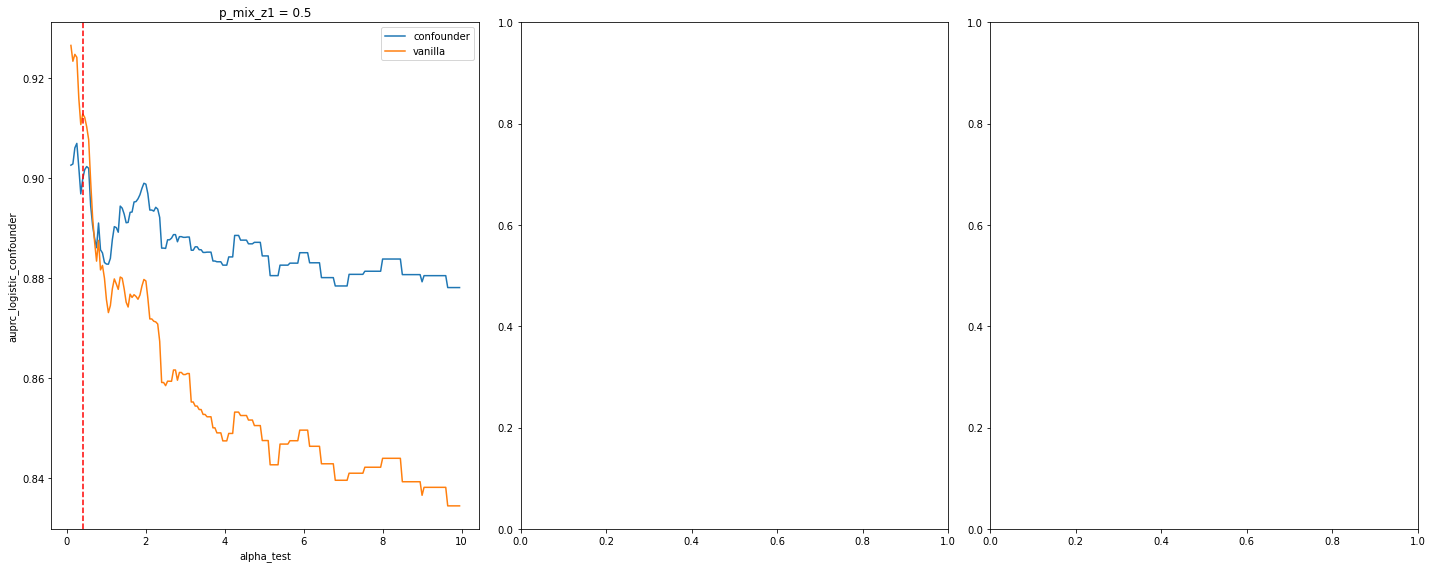

In [1066]:
xlabel = "alpha_test"

p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,8))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    _df = df[df['p_mix_z1'] == k].sort_values("alpha_test")
    
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', ax=ax[idx], label="confounder")
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', ax=ax[idx], label="vanilla")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_confounder'], label="confounder")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_vanilla'], label="vanilla")
    
    ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()
plt.tight_layout()

In [1067]:
df.columns

Index(['auprc_logistic_confounder', 'auprc_logistic_vanilla',
       'auprc_logistic_confounder_df0', 'auprc_logistic_confounder_df1',
       'precision_confounder', 'recall_confounder', 'f1_confounder',
       'precision_confounder_df0', 'recall_confounder_df0',
       'f1_confounder_df0', 'precision_confounder_df1',
       'recall_confounder_df1', 'f1_confounder_df1',
       'auprc_logistic_vanilla_df0', 'auprc_logistic_vanilla_df1',
       'precision_vanilla', 'recall_vanilla', 'f1_vanilla',
       'precision_vanilla_df0', 'recall_vanilla_df0', 'f1_vanilla_df0',
       'precision_vanilla_df1', 'recall_vanilla_df1', 'f1_vanilla_df1',
       'p_pos_train_z0', 'p_pos_train_z1', 'p_pos_train', 'p_pos_test',
       'p_mix_z0', 'p_mix_z1', 'alpha_train', 'alpha_test', 'p_pos_test_z0',
       'p_pos_test_z1', 'C_y', 'C_z', 'n_train', 'n_test', 'n_z0_pos_train',
       'n_z0_neg_train', 'n_z0_pos_test', 'n_z0_neg_test', 'n_z1_pos_train',
       'n_z1_neg_train', 'n_z1_pos_test', 'n_z1_neg_t

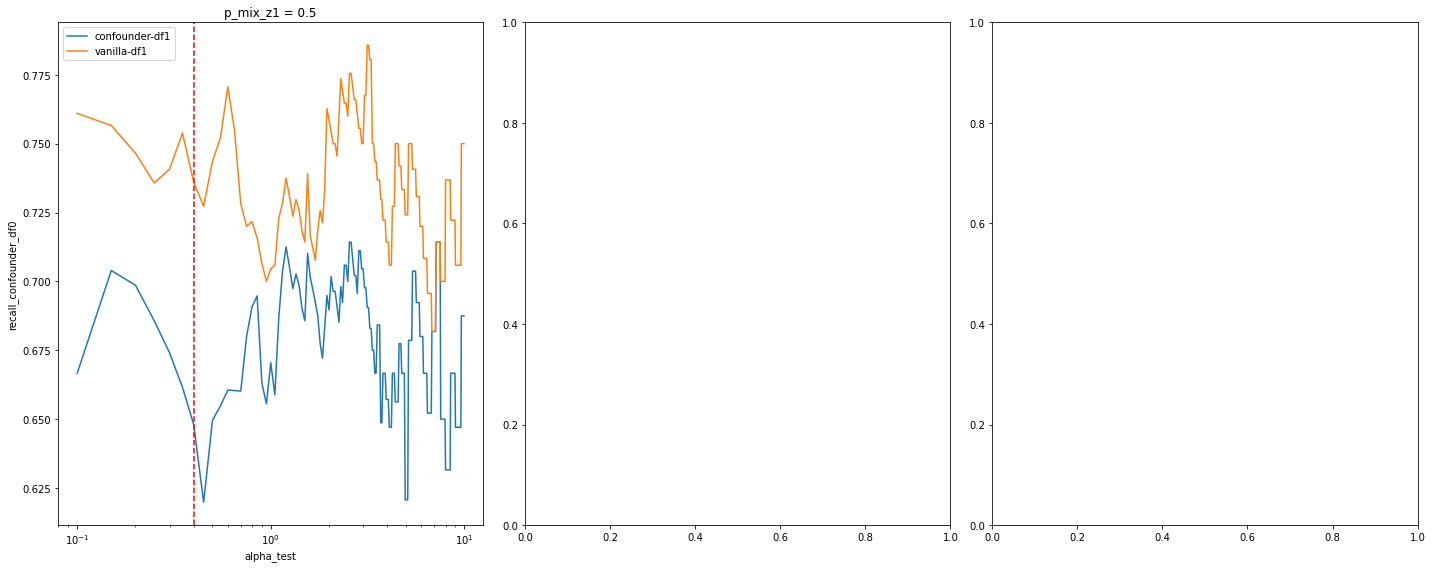

In [1072]:
xlabel = "alpha_test"

p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,8))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    _df = df[df['p_mix_z1'] == k].sort_values("alpha_test")
    
    # sns.lineplot(data=_df, x=xlabel, y='recall_confounder_df0', ax=ax[idx], label="confounder-df0")
    g_results=sns.lineplot(data=_df, x=xlabel, y='recall_confounder_df0', ax=ax[idx], label="confounder-df1")
    # sns.lineplot(data=_df, x=xlabel, y='recall_vanilla_df0', ax=ax[idx], label="vanilla-df0")
    g_results=sns.lineplot(data=_df, x=xlabel, y='recall_vanilla_df0', ax=ax[idx], label="vanilla-df1")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_confounder'], label="confounder")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_vanilla'], label="vanilla")
    g_results.set(xscale="log")
    
    ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()
plt.tight_layout()

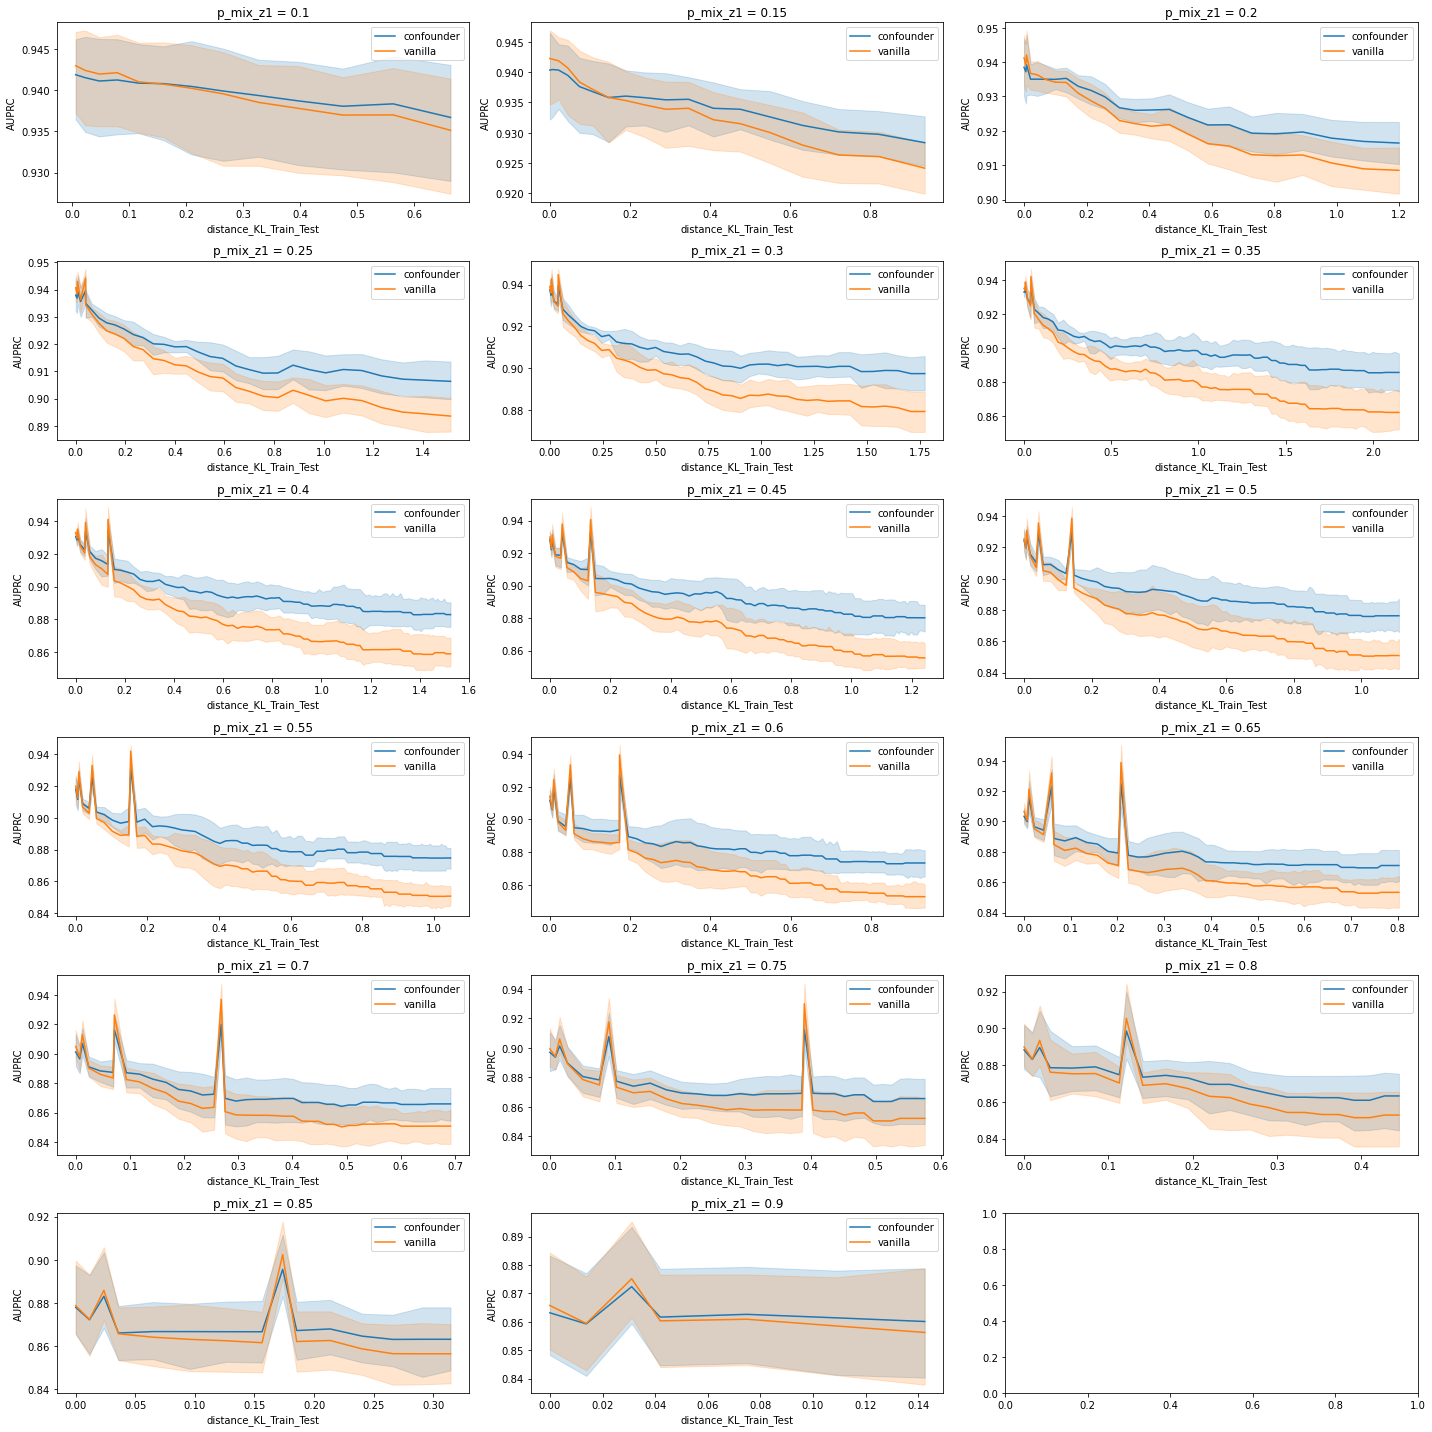

In [866]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,20))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "distance_KL_Train_Test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', ax=ax[idx], label="confounder")
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', ax=ax[idx], label="vanilla")
    
    ax[idx].set_xlabel(xlabel)
    ax[idx].set_ylabel("AUPRC")
    # ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()

plt.tight_layout()

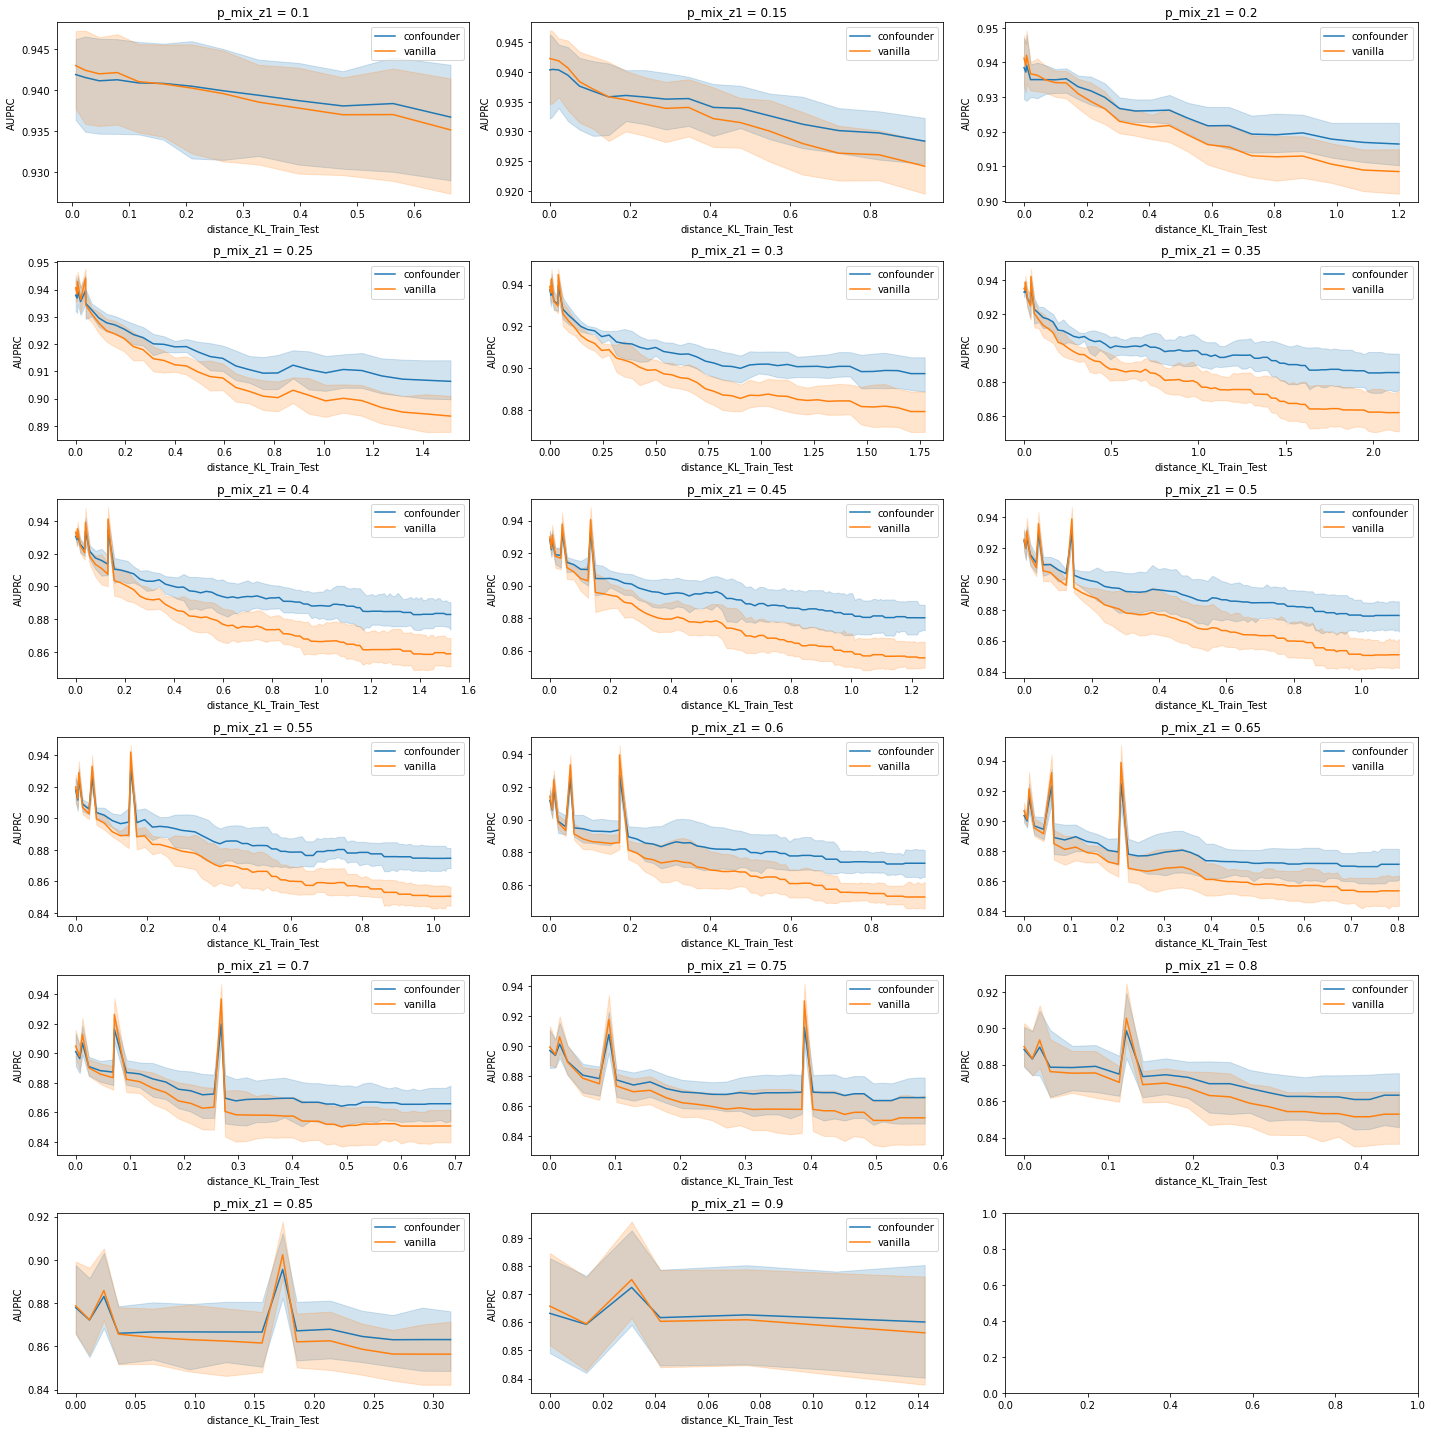

In [863]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,20))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "distance_KL_Train_Test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', ax=ax[idx], label="confounder")
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', ax=ax[idx], label="vanilla")
    
    ax[idx].set_xlabel(xlabel)
    ax[idx].set_ylabel("AUPRC")
    # ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()

plt.tight_layout()

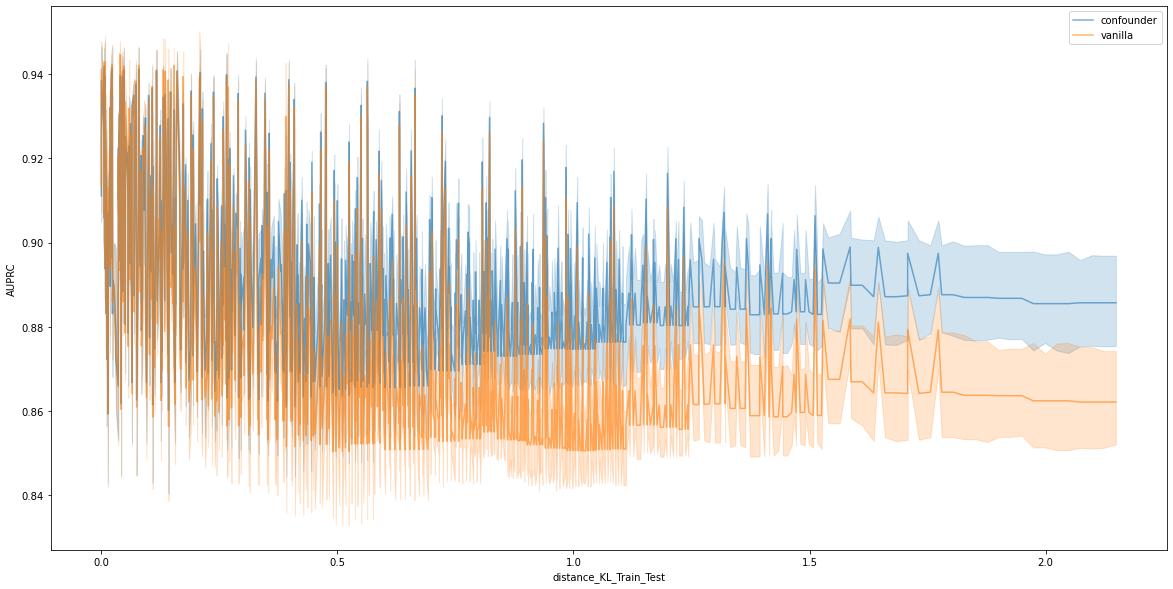

In [864]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(1,1, figsize=(20,10))

xlabel = "distance_KL_Train_Test"
_df = df.sort_values(xlabel)

sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', label="confounder", alpha=0.6)
sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', label="vanilla", alpha=0.6)

# ax.plot(_df[xlabel], _df['auprc_logistic_confounder'], label="confounder", alpha=0.6)
# ax.plot(_df[xlabel], _df['auprc_logistic_vanilla'], label="vanilla", alpha=0.6)

ax.set_xlabel(xlabel)
ax.set_ylabel("AUPRC")
# ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
ax.legend()


In [ ]:

fig, ax = plt.subplots(1,2, figsize=(28,10))
xlabel = "distance_KL_Test_Train"
_df = df.sort_values(xlabel)

for idx, k in enumerate(["auprc_logistic_vanilla", "auprc_logistic_confounder"]):
    
    im = ax[idx].scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df[k], cmap='Blues')
    im.set_clim(0.8,1)
    ax[idx].set_xlabel("p_pos_test_z0")
    ax[idx].set_ylabel("p_pos_test_z1")
    ax[idx].set_title(k)

    fig.colorbar(im, ax=ax[idx])

In [ ]:
# from matplotlib import cm

# fig, ax = plt.subplots(1,1)
# xlabel = "distance_KL_Test_Train"
# _df = df.sort_values(xlabel)


# im = ax.scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df["auprc_logistic_confounder"], cmap='Blues')
# im.set_clim(0.8,1)
# plt.xlabel("p_pos_test_z0")
# plt.ylabel("p_pos_test_z1")
# plt.title("AUPRC of LR with confounder")

# fig.colorbar(im, ax=ax)

# from matplotlib import cm

# fig, ax = plt.subplots(1,1)
# xlabel = "distance_KL_Test_Train"
# _df = df.sort_values(xlabel)


# im = ax.scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df["auprc_logistic_vanilla"], cmap='Blues')
# im.set_clim(0.8,1)
# plt.title('vanilla LR')
# fig.colorbar(im, ax=ax)

In [ ]:
df

In [ ]:
df.query("0.67 < distance_KL_Test_Train < 0.75").sort_values("distance_KL_Test_Train")

## Check some diagnosis

### Corr Plot

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.DataFrame(x_transform_test).iloc[:, :].corr(), vmin=-1, vmax=1)

### R2

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_true=y_test, y_pred=y_probs_vanilla[:, 1])

In [ ]:
r2_score(y_true=y_test, y_pred=y_probs_confound[:, 1])

In [ ]:
def r2AndAdjusted(y_true, y_pred, np):
    n = len(y_true)
    
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    r2_adjusted = 1-(1-r2)*(n-1)/(n-np-1)
    
    return r2, r2_adjusted
    

In [ ]:
r2AndAdjusted(y_true=y_test, y_pred=y_probs_vanilla[:, 1], np=384)

In [ ]:
# auprc_logistic_confounder

# auprc_logistic_vanilla

In [ ]:
x_transform_train.shape

### Deviance Residuals

In [ ]:
def deviance(X, y, model):
    return 2*metrics.log_loss(y, model.predict_proba(X), normalize=False)

In [ ]:
deviance(X=x_transform_test, y=y_test, model=clf_vanilla)

### Calibration

In [942]:
from sklearn.calibration import calibration_curve


In [ ]:
prob_true_vanilla, prob_pred_vanilla = calibration_curve(y_true=y_test, y_prob=y_probs_vanilla[:,1], n_bins=10)
prob_true_confound, prob_pred_confound = calibration_curve(y_true=y_test, y_prob=y_probs_confound[:,1], n_bins=10)


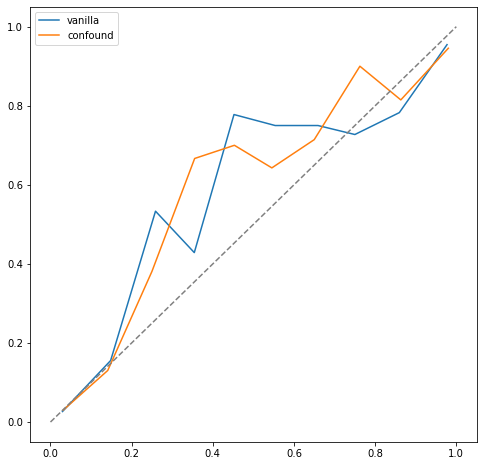

In [943]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(prob_pred_vanilla, prob_true_vanilla, label='vanilla')
ax.plot(prob_pred_confound, prob_true_confound, label='confound')

ax.plot([0,1],[0,1], "--", color='gray')
ax.legend()


In [946]:
prob_true_vanilla_df0, prob_pred_vanilla_df0 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_prob=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1], n_bins=10)
prob_true_vanilla_df1, prob_pred_vanilla_df1 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_prob=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1], n_bins=10)

prob_true_confound_df0, prob_pred_confound_df0 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_prob=y_probs_confound[df_test[domain_col] == z_Categories[0],1], n_bins=10)
prob_true_confound_df1, prob_pred_confound_df1 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_prob=y_probs_confound[df_test[domain_col] == z_Categories[1],1], n_bins=10)



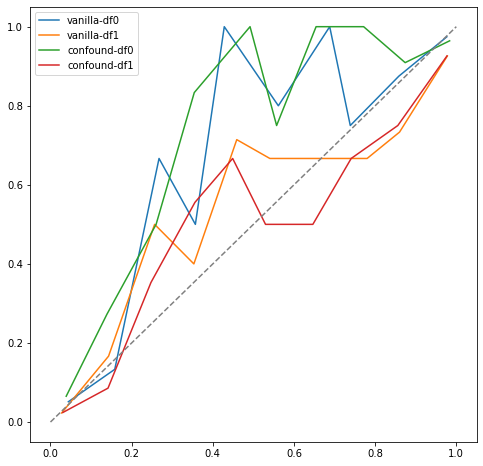

In [947]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(prob_pred_vanilla_df0, prob_true_vanilla_df0, label='vanilla-df0')
ax.plot(prob_pred_vanilla_df1, prob_true_vanilla_df1, label='vanilla-df1')

ax.plot(prob_pred_confound_df0, prob_true_confound_df0, label='confound-df0')
ax.plot(prob_pred_confound_df1, prob_true_confound_df1, label='confound-df1')

ax.plot([0,1],[0,1], "--", color='gray')
ax.legend()


In [951]:
# y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1])

metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], 
                 y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5
                )


0.883720930232558

In [952]:
metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], 
                 y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5
                )

0.7096774193548386

In [953]:
# y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1])

metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], 
                 y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5
                )


0.8548387096774193

In [954]:
# y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1])

metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], 
                 y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5
                )


0.6984126984126985